In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import keras_tuner as kt
from sklearn import metrics

In [3]:
df_insurance_claims = pd.read_csv("./Insurance_claims.csv")

## Model 1: The Simple model based on the incident occurs within t days of the subscription date.
### Data Pre-processing

In [4]:
df_insurance_claims.head()

,ReferenceId,PolicyholderNumber,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,InsurerNotes,PolicyholderOccupation,LossDate,FirstPolicySubscriptionDate,ClaimCause,ClaimInvolvedCovers,...,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud
0,4842,531112,715507.0,NaN,avoids a cat and hits a garage pole With deduc...,CivilServant,1/2/19,6/18/18,CollisionWithAnimal,MaterialDamages ActLiability,...,1,104.0,0.25,1,4624.73,8.0,45.0,0,1.0,0
1,4844,87170,71164.0,NaN,accident only expert contacts us to inform us ...,Worker,1/2/19,6/29/17,LossOfControl,MaterialDamages ActLiability,...,3,230.0,0.50,1,1606.81,11.0,20.0,0,1.0,0
2,4848,98706,442609.0,NaN,ae Miss/ for garage change A/ setting up EAD/ ...,Worker,1/2/19,2/5/17,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability,...,9,93.0,0.25,0,998.20,18.0,32.0,0,0.5,0
3,4849,38240,24604.0,NaN,"awaiting report to determine rc, no box checke...",CivilServant,1/2/19,1/21/17,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability ReplacementVehicle,...,2,56.0,0.25,0,2506.92,11.0,46.0,0,0.5,0
4,4850,11339,2933.0,229134.0,Insured in THIRD-PARTY formula Insured in a su...,Farmer,1/2/19,1/13/18,AccidentWithIdentifiedThirdParty,ActLiability,...,4,110.0,0.25,0,12.00,12.0,28.0,0,0.0,0


In [5]:
# Check the missing values for each column
df_insurance_claims.isna().sum()

ReferenceId                            0
PolicyholderNumber                     0
FirstPartyVehicleNumber              495
ThirdPartyVehicleNumber            11151
InsurerNotes                        2357
PolicyholderOccupation               343
LossDate                               0
FirstPolicySubscriptionDate            0
ClaimCause                           197
ClaimInvolvedCovers                  195
DamageImportance                   10792
FirstPartyVehicleType                 12
ConnectionBetweenParties           11432
LossPostCode                        1408
PolicyHolderPostCode                   0
PolicyWasSubscribedOnInternet          0
NumberOfPoliciesOfPolicyholder         0
FpVehicleAgeMonths                    12
EasinessToStage                        0
ClaimWihoutIdentifiedThirdParty        0
ClaimAmount                            0
LossHour                              94
PolicyHolderAge                       36
NumberOfBodilyInjuries                 0
FirstPartyLiabil

In [6]:
# Check the unique values for each column
df_insurance_claims.nunique()

ReferenceId                        11530
PolicyholderNumber                  9404
FirstPartyVehicleNumber             9431
ThirdPartyVehicleNumber              350
InsurerNotes                        9040
PolicyholderOccupation                11
LossDate                             804
FirstPolicySubscriptionDate         1389
ClaimCause                            18
ClaimInvolvedCovers                   68
DamageImportance                       2
FirstPartyVehicleType                  4
ConnectionBetweenParties               5
LossPostCode                        3004
PolicyHolderPostCode                3130
PolicyWasSubscribedOnInternet          2
NumberOfPoliciesOfPolicyholder        17
FpVehicleAgeMonths                   388
EasinessToStage                        4
ClaimWihoutIdentifiedThirdParty        2
ClaimAmount                         8248
LossHour                              24
PolicyHolderAge                       73
NumberOfBodilyInjuries                 6
FirstPartyLiabil

#### For the model 1, we want to find out which claims are suspicious if the incident occurs within t days of subscription date. Therefore, we only need columns:
- FirstPolicySubscriptionDate
- LossDate
- Fraud

In [7]:
df_insurance_claims_model_1 = df_insurance_claims[["LossDate", "FirstPolicySubscriptionDate", "Fraud"]]
df_insurance_claims_model_1

,LossDate,FirstPolicySubscriptionDate,Fraud
0,1/2/19,6/18/18,0
1,1/2/19,6/29/17,0
2,1/2/19,2/5/17,0
3,1/2/19,1/21/17,0
4,1/2/19,1/13/18,0
...,...,...,...
11525,2/17/21,3/15/19,0
11526,3/7/21,7/20/17,0
11527,3/15/21,9/30/20,0
11528,3/6/21,12/28/18,0


#### Based on the "LossDate" and "FirstPolicySubscriptionDate", we calculated the gap days as "Days" between these two columns

In [8]:
df_insurance_claims_model_1["LossDate"] = pd.to_datetime(df_insurance_claims_model_1["LossDate"])
df_insurance_claims_model_1["FirstPolicySubscriptionDate"] = pd.to_datetime(df_insurance_claims_model_1["FirstPolicySubscriptionDate"])

/var/folders/4c/6jy3z6sn7zg_n_24fwj6v_xw0000gn/T/ipykernel_39199/1508960330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insurance_claims_model_1["LossDate"] = pd.to_datetime(df_insurance_claims_model_1["LossDate"])
/var/folders/4c/6jy3z6sn7zg_n_24fwj6v_xw0000gn/T/ipykernel_39199/1508960330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insurance_claims_model_1["FirstPolicySubscriptionDate"] = pd.to_datetime(df_insurance_claims_model_1["FirstPolicySubscriptionDate"])


In [9]:
df_insurance_claims_model_1["Days"] = df_insurance_claims_model_1["LossDate"] - df_insurance_claims_model_1["FirstPolicySubscriptionDate"]
df_insurance_claims_model_1["Days"] = pd.to_numeric(df_insurance_claims_model_1["Days"].dt.days, downcast='integer')
df_insurance_claims_model_1 = df_insurance_claims_model_1.astype({"Days": "int64"})

/var/folders/4c/6jy3z6sn7zg_n_24fwj6v_xw0000gn/T/ipykernel_39199/3779345626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insurance_claims_model_1["Days"] = df_insurance_claims_model_1["LossDate"] - df_insurance_claims_model_1["FirstPolicySubscriptionDate"]
/var/folders/4c/6jy3z6sn7zg_n_24fwj6v_xw0000gn/T/ipykernel_39199/3779345626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insurance_claims_model_1["Days"] = pd.to_numeric(df_insurance_claims_model_1["Days"].dt.days, downcast='integer')


In [10]:
df_insurance_claims_model_1

,LossDate,FirstPolicySubscriptionDate,Fraud,Days
0,2019-01-02,2018-06-18,0,198
1,2019-01-02,2017-06-29,0,552
2,2019-01-02,2017-02-05,0,696
3,2019-01-02,2017-01-21,0,711
4,2019-01-02,2018-01-13,0,354
...,...,...,...,...
11525,2021-02-17,2019-03-15,0,705
11526,2021-03-07,2017-07-20,0,1326
11527,2021-03-15,2020-09-30,0,166
11528,2021-03-06,2018-12-28,0,799


In [11]:
df_insurance_claims_model_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11530 entries, 0 to 11529
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   LossDate                     11530 non-null  datetime64[ns]
 1   FirstPolicySubscriptionDate  11530 non-null  datetime64[ns]
 2   Fraud                        11530 non-null  int64         
 3   Days                         11530 non-null  int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 360.4 KB


#### Determine the range of the t days

In [12]:
df_fraud = df_insurance_claims_model_1.loc[df_insurance_claims_model_1["Fraud"] == 1]

In [13]:
# The maximum value of t
df_fraud["Days"].max()

1201

In [14]:
# The minimum value of t
df_fraud["Days"].min()

0

In [15]:
# Set up the range of t days
t = range(1202)

#### We calculated the detection rate and hit rate based on the each t days
- The calculation formula of detection rate is:
$$
  Detection\ Rate =\frac{The\ Number\ of\ Detection}{Total\ Number\ of\ Observation}\, *100\%
$$
- The calculation formula of hit rate is:
$$
  Hit\ Rate =\frac{The\ Number\ of\ Real\ Fraud}{The\ Number\ of\ Detection}\, *100\%
$$


In [16]:
def detect_fraudulent_claims_model_1(t, df_datasets):
    
    # All_detection rate
    d = []
    # All hit rate
    h = []
    # All predictions 
    Y_all_prediction = []
    
    for i in t:
        # All prediction based on each t
        y_prediction = []
        # The number of detection
        a = 0
        # The number of real fraud
        b = 0
        
        for o in range(len(df_datasets)):
            if df_datasets["Days"][o] <= i:
                a = a + 1
                y = 1
                y_prediction.append(y)
                if df_datasets["Fraud"][o] == 1:
                    b = b + 1
            else:
                y = 0
                y_prediction.append(y)
        
        detection_rate = round((a / len(df_datasets))*100, 2)
        d.append(detection_rate)
        hit_rate = round((b / a)*100, 2)
        h.append(hit_rate)
        
        Y_all_prediction.append(y_prediction)

    
    return d, h, Y_all_prediction

In [17]:
d, h, Y_all_prediction = detect_fraudulent_claims_model_1(t, df_insurance_claims_model_1)

### The hit rate and detection rate of this model for different values of t are:

#### The hit rate (from t equals 0 to 1201)

In [18]:
h

[34.15,
 24.66,
 28.85,
 26.45,
 23.46,
 22.34,
 21.7,
 20.38,
 19.23,
 18.81,
 18.73,
 18.45,
 17.08,
 16.27,
 16.5,
 16.04,
 15.87,
 15.63,
 15.54,
 15.31,
 14.86,
 14.31,
 14.21,
 14.04,
 14.09,
 13.87,
 13.65,
 13.4,
 13.29,
 13.16,
 12.73,
 12.47,
 12.24,
 12.05,
 11.83,
 11.64,
 11.46,
 11.24,
 11.07,
 10.86,
 10.65,
 10.48,
 10.34,
 10.18,
 9.99,
 9.83,
 9.67,
 9.58,
 9.44,
 9.26,
 9.11,
 8.97,
 8.83,
 8.73,
 8.63,
 8.52,
 8.39,
 8.23,
 8.12,
 8.01,
 7.91,
 7.82,
 7.76,
 7.65,
 7.56,
 7.44,
 7.34,
 7.23,
 7.17,
 7.09,
 7.1,
 7.08,
 7.0,
 6.92,
 6.85,
 6.79,
 6.7,
 6.63,
 6.58,
 6.5,
 6.45,
 6.37,
 6.32,
 6.26,
 6.2,
 6.15,
 6.11,
 6.05,
 5.99,
 5.92,
 5.86,
 5.81,
 5.75,
 5.7,
 5.64,
 5.59,
 5.56,
 5.53,
 5.49,
 5.45,
 5.41,
 5.37,
 5.33,
 5.3,
 5.27,
 5.22,
 5.16,
 5.13,
 5.1,
 5.07,
 5.04,
 5.01,
 4.98,
 4.96,
 4.92,
 4.89,
 4.88,
 4.84,
 4.81,
 4.8,
 4.77,
 4.76,
 4.73,
 4.7,
 4.66,
 4.63,
 4.6,
 4.57,
 4.53,
 4.49,
 4.47,
 4.44,
 4.41,
 4.39,
 4.37,
 4.35,
 4.32,
 4.3,
 4.29

#### The detection rate (from t equals 0 to 1201)

In [19]:
d

[0.36,
 0.63,
 0.9,
 1.05,
 1.41,
 1.71,
 2.04,
 2.25,
 2.48,
 2.63,
 2.73,
 2.91,
 3.15,
 3.3,
 3.52,
 3.68,
 3.82,
 4.05,
 4.24,
 4.36,
 4.55,
 4.73,
 4.88,
 5.07,
 5.17,
 5.32,
 5.46,
 5.57,
 5.74,
 5.93,
 6.13,
 6.26,
 6.37,
 6.48,
 6.6,
 6.7,
 6.81,
 6.95,
 7.05,
 7.19,
 7.33,
 7.45,
 7.55,
 7.67,
 7.81,
 7.94,
 8.07,
 8.24,
 8.36,
 8.53,
 8.66,
 8.8,
 8.93,
 9.04,
 9.15,
 9.26,
 9.4,
 9.59,
 9.72,
 9.85,
 9.98,
 10.09,
 10.17,
 10.31,
 10.44,
 10.61,
 10.75,
 10.91,
 11.01,
 11.14,
 11.24,
 11.39,
 11.52,
 11.65,
 11.78,
 11.88,
 12.05,
 12.16,
 12.26,
 12.4,
 12.51,
 12.65,
 12.77,
 12.89,
 13.0,
 13.1,
 13.21,
 13.33,
 13.46,
 13.62,
 13.77,
 13.89,
 14.03,
 14.15,
 14.29,
 14.43,
 14.51,
 14.58,
 14.7,
 14.8,
 14.92,
 15.01,
 15.13,
 15.23,
 15.31,
 15.45,
 15.63,
 15.72,
 15.8,
 15.91,
 16.0,
 16.09,
 16.18,
 16.26,
 16.39,
 16.49,
 16.54,
 16.65,
 16.76,
 16.8,
 16.9,
 16.95,
 17.05,
 17.16,
 17.29,
 17.42,
 17.55,
 17.66,
 17.81,
 17.94,
 18.05,
 18.17,
 18.28,
 18.37,
 18.

### Plot the results of detection rate and hit rate

Text(0, 0.5, 'Hit Rate')

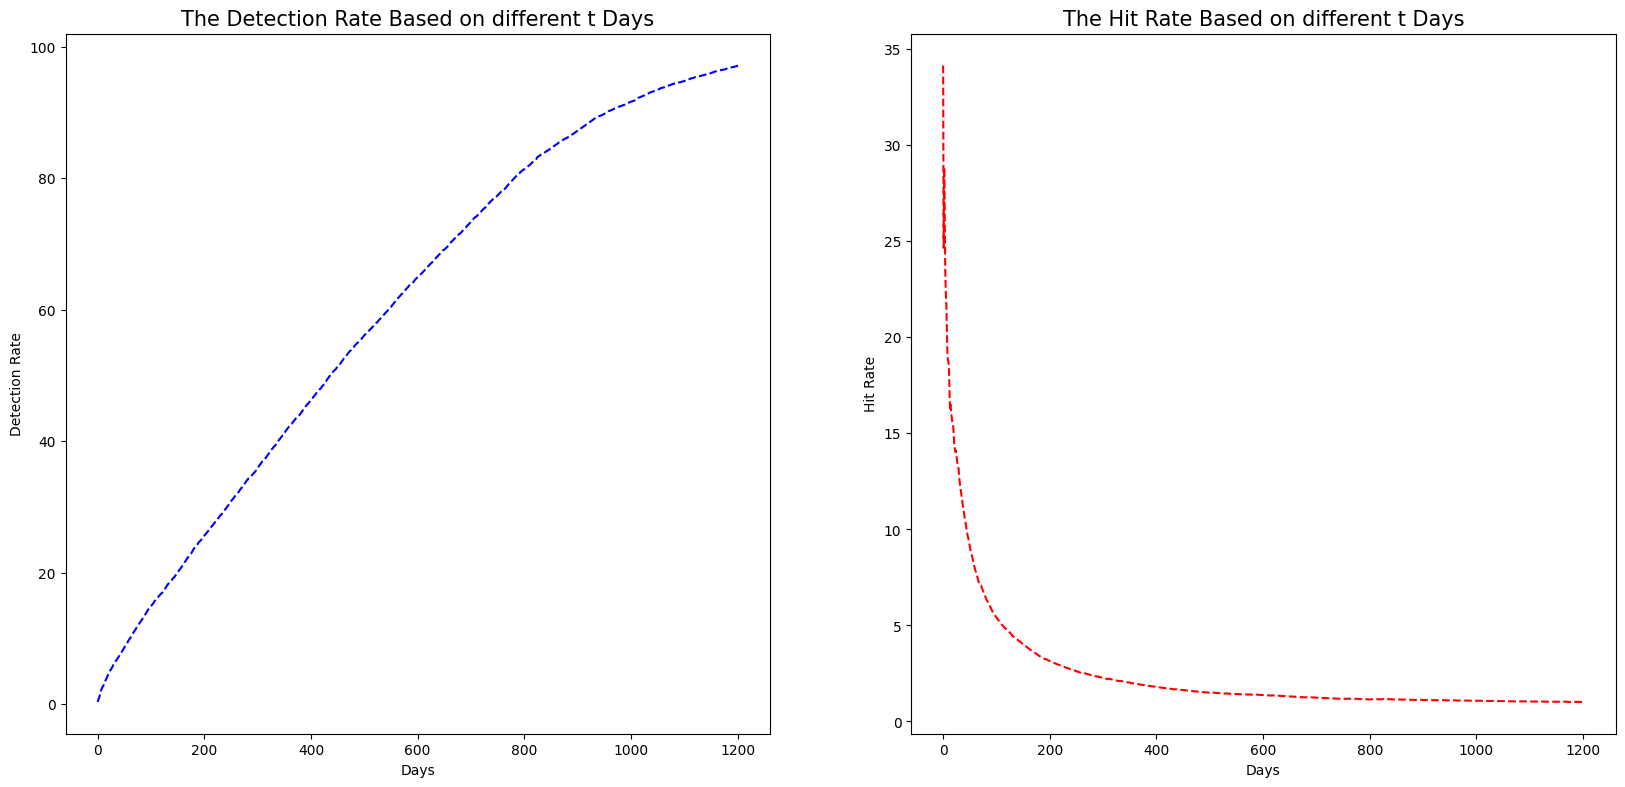

In [20]:
fig = plt.figure(figsize = (20, 20))
AX1 = fig.add_subplot(2,2,1)
AX2 = fig.add_subplot(2,2,2)

AX1.plot(t, d, ls = "--", color = "blue")
AX2.plot(t, h, ls = "--", color = "red")

AX1.set_title("The Detection Rate Based on different t Days", fontsize = 15, horizontalalignment="center")
AX2.set_title("The Hit Rate Based on different t Days", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("Days", fontsize = 10)
AX1.set_ylabel("Detection Rate", fontsize = 10)

AX2.set_xlabel("Days", fontsize = 10)
AX2.set_ylabel("Hit Rate", fontsize = 10)

In order to choose a sensible value of t, we used Receiver Operating Characteristic(ROC) accuracy to evaluate which t is the sensible one. 

A large ROC accuracy indicates that this model with a specific t is able to accurately identify suspicious claims while minimizing the number of false positives. 

- The calculation formula of ROC accuracy is:

$$
  ROC\ Accuracy =\frac{TP\ +\ TN}{TP\ +\ TN\ +\ FP\ +\ FN}
$$


In [21]:
def get_all_roc_accuracy(y, y_hat):
    all_roc_acc = []
    for i in range(len(t)):
        roc_acc = round(metrics.roc_auc_score(y, y_hat[i]), 2)
        all_roc_acc.append(roc_acc)
    return all_roc_acc

In [22]:
all_roc_acc = get_all_roc_accuracy(df_insurance_claims_model_1["Fraud"], Y_all_prediction)

#### The ROC accuracy of the model (from t equals 0 to 1201)

In [23]:
all_roc_acc

[0.56,
 0.58,
 0.63,
 0.64,
 0.66,
 0.68,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.76,
 0.76,
 0.78,
 0.78,
 0.79,
 0.8,
 0.81,
 0.82,
 0.82,
 0.82,
 0.83,
 0.83,
 0.84,
 0.85,
 0.85,
 0.85,
 0.86,
 0.87,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.85,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.84,
 0.84,
 0.84,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,


### Plot the ROC accuracy based on each t days

Text(0, 0.5, 'ROC accuracy')

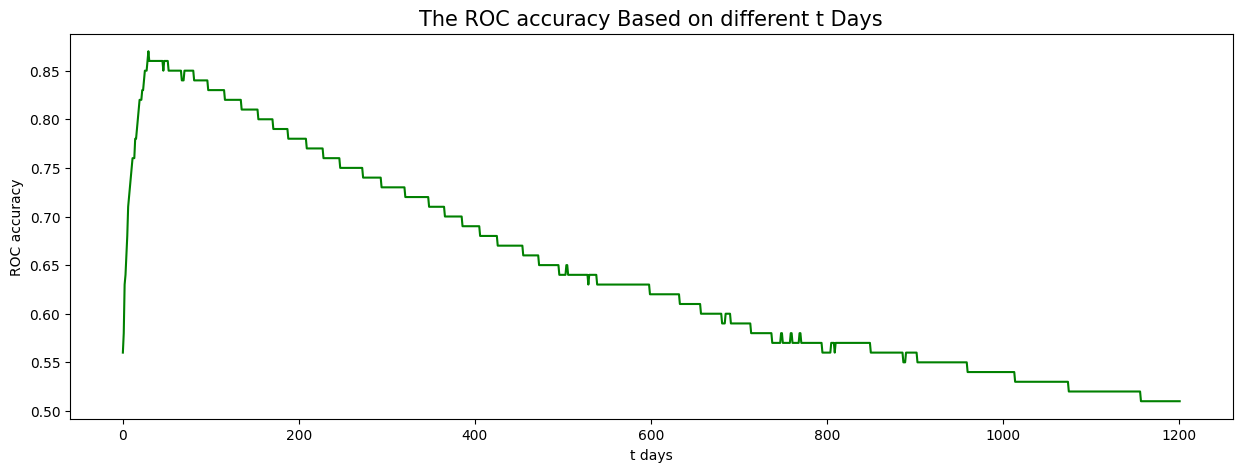

In [24]:
fig = plt.figure(figsize = (15, 5))
AX1 = fig.add_subplot(1,1,1)

AX1.plot(t, all_roc_acc, ls = "-", color = "green")

AX1.set_title("The ROC accuracy Based on different t Days", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("t days", fontsize = 10)
AX1.set_ylabel("ROC accuracy", fontsize = 10)


### Find out the sensible t of this model

In [25]:
for i in range(len(all_roc_acc)):
    if all_roc_acc[i] == max(all_roc_acc):
        print("The sensible t is " + str(i))
        print("The detection rate is " + str(d[i]) + "%")
        print("The hit rate is " + str(h[i]) + "%")
        print("The ROC accuracy of the model is " + str(all_roc_acc[i]))

The sensible t is 29
The detection rate is 5.93%
The hit rate is 13.16%
The ROC accuracy of the model is 0.87


### The logic underlies this model and its bias

The logic underlying this model is that when a customer subscribes to a service, it is more likely that fraudulent claims will be made shortly after the subscription date. Therefore, by setting a threshold for how soon a claim can be made after the subscription date, it is possible to identify suspicious claims. This threshold can then be adjusted to find a balance between the hit rate and detection rate for the model.


However, this model has the potential to discriminate against customers who make claims shortly after subscribing to a service, as these claims will be flagged as suspicious regardless of their validity. That would damage the customers' trust relationship with the company. Additionally, if the threshold is set too low, then the model may also falsely flag legitimate claims as suspicious.